In [1]:
import os
import sys
from pathlib import Path

CWD = [p for p in Path().resolve().parents if p.stem == "eco-nsr"][0]
sys.path.append(CWD.as_posix())
sys.path.append(os.path.join(CWD, "src", "representation", "PyTorch_VAE"))

In [ ]:
from typing import OrderedDict
from copy import deepcopy

import torch
import numpy as np
from yacs.config import CfgNode
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, Resize
from sklearn.cluster import MeanShift
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from src.data.RavenMatrices import RavenMatrices
from src.data.RavenShapes import RavenShapes
from src.representation.PyTorch_VAE.models import *  # noqa: F403

In [3]:
def show_image(img: np.ndarray) -> None:
    """
    Recieve numpy array of shape [channels, height, width] and display it using pyplot
    """
    if len(img.shape) == 3:
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.axis("off")
        plt.show()
    if len(img.shape) == 4:
        for i in range(img.shape[0]):
            plt.subplot(img.shape[0], 1, i + 1)
            plt.imshow(np.transpose(img[i], (1, 2, 0)))
            plt.axis("off")
        plt.show()
    else:
        raise ValueError("Invalid image shape")

def crop_img(img: np.ndarray, bbox: list[float]) -> np.ndarray:
    """
    Use bbox to crop an image to a single panel.

    Parameters
    ----------
    img : np.ndarray
        Panel image of shape [channels, height, width]
    bbox : list[float]
        Shape bounding box
    """
    if len(img.shape) == 3:
        return img[:, int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])]
    if len(img.shape) == 4:
        return img[:, :, int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])]
    else:
        raise ValueError("Invalid image shape")


def sample_z(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    Sample from a Gaussian distribution defined by mu and logvar. Identical to model.reparametrize

    Parameters
    ----------
    mu : torch.Tensor
        Mean of the Gaussian distribution.
    logvar : torch.Tensor
        Log variance of the Gaussian distribution.

    Returns
    -------
    torch.Tensor
        Sampled tensor from the Gaussian distribution.
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [4]:
with open(os.path.join(CWD, "global_cfg.yml"), "r") as f:
    global_cfg = CfgNode.load_cfg(f)

In [5]:
model = vae_models[global_cfg.REPRESENTATION.MODEL.name](  # noqa: F405
    hidden_dims=[32] * int(np.log2(global_cfg.REPRESENTATION.TRAINING.patch_size / 4)),
    **global_cfg.REPRESENTATION.MODEL,
)

checkpoint = torch.load(
    os.path.join(
        CWD,
        global_cfg.REPRESENTATION.TRAINING.output,
        global_cfg.REPRESENTATION.MODEL.name,
        "version_0",
        "checkpoints",
        "last.ckpt",
    ),
    weights_only=True,
)

model_state_dict = OrderedDict()
for key in checkpoint["state_dict"].keys():
    if key.startswith("model."):
        model_state_dict[key[6:]] = checkpoint["state_dict"][key]
    else:
        model_state_dict[key] = checkpoint["state_dict"][key]

model.load_state_dict(model_state_dict)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

BetaTCVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc): Linear(in_features=512, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=6, bias=True)
  (fc_var): Linear(in_features=256, out_features=6, bias=True)
  (decoder_input): Linear(in_features=6, out_

In [6]:
matrices = RavenMatrices(
    os.path.join(global_cfg.DATA.path, "RAVEN-F"),
    os.path.join(CWD, global_cfg.DATA.RavenMatrices.dataset_file),
    transform=Compose([
        ToTensor(),
    ]),
)

shapes = RavenShapes(
    os.path.join(global_cfg.DATA.path, "RAVEN-F"),
    os.path.join(CWD, global_cfg.DATA.RavenShapes.dataset_file),
    transform=Compose([
        ToTensor(),
        Resize((
            global_cfg.REPRESENTATION.TRAINING.patch_size,
            global_cfg.REPRESENTATION.TRAINING.patch_size,
        ))
    ])
)

sample_ds, _ = random_split(shapes, [0.05, 0.95])  # used to find dim ranges
sample_loader = DataLoader(
    sample_ds, batch_size=128, shuffle=False, num_workers=16, pin_memory=True, drop_last=False
)

**_Latent Traversals_**

In [17]:
minim = torch.zeros(1, 6)
maxim = torch.zeros(1, 6)

for img in tqdm(sample_loader):
    img = img.to(device)
    with torch.no_grad():
        mu, logvar = model.encode(img)
        z = sample_z(mu, logvar)
    z = z.cpu()
    minim = torch.min(minim, torch.min(z, dim=0).values)
    maxim = torch.max(maxim, torch.max(z, dim=0).values)

for i in range(6):
    print(f"Dimension {i}: Min = {minim[0, i]}, Max = {maxim[0, i]}")

100%|██████████| 749/749 [00:17<00:00, 42.53it/s]

Dimension 0: Min = -5.916942596435547, Max = 5.1746721267700195
Dimension 1: Min = -0.747459888458252, Max = 4.116666793823242
Dimension 2: Min = -2.9776971340179443, Max = 4.406064033508301
Dimension 3: Min = -2.3265938758850098, Max = 4.072992324829102
Dimension 4: Min = -3.260138750076294, Max = 3.3236539363861084
Dimension 5: Min = -5.006469249725342, Max = 2.9367284774780273


In [ ]:
sample = matrices[0]
img = crop_img(sample[0]["img"], sample[0]["locs"][0])
img = Resize((
    global_cfg.REPRESENTATION.TRAINING.patch_size,
    global_cfg.REPRESENTATION.TRAINING.patch_size,
))(img)

img = img.to(device)

with torch.no_grad():
    mu, logvar = model.encode(img.unsqueeze(0))
    z = sample_z(mu, logvar).cpu()

for dim in range(global_cfg.REPRESENTATION.MODEL.latent_dim):
    _z = copy

torch.Size([1, 6])

In [ ]:
img = crop_img(sample[0]["img"], sample[0]["locs"][0])
img = Resize((
    global_cfg.REPRESENTATION.TRAINING.patch_size,
    global_cfg.REPRESENTATION.TRAINING.patch_size,
))(img)

img = img.to("cuda:0")
model = model.to("cuda:0")

with torch.no_grad():
    mu, logvar = model.encode(img.unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0313128..1.0].


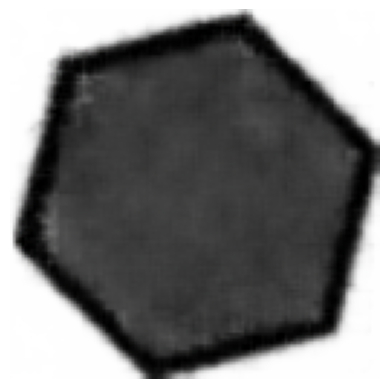

In [9]:
z = sample_z(mu, logvar)

with torch.no_grad():
    recon = model.decode(z)

show_image(recon.squeeze(0).cpu())

In [ ]:
tnsr: torch.Tensor = torch.tensor(0)
for s in sample:
    img = s["img"]
    for box in s["locs"]:
        cropped_img = crop_img(img, box)
        resized_img = Resize((
            global_cfg.REPRESENTATION.TRAINING.patch_size,
            global_cfg.REPRESENTATION.TRAINING.patch_size,
        ))(cropped_img)
        tnsr = (
            resized_img.unsqueeze(0)
            if tnsr.dim() == 0
            else torch.cat((tnsr, resized_img.unsqueeze(0)), dim=0)
        )

tnsr = tnsr.to("cuda:0")

In [ ]:
with torch.no_grad():
    mu, logvar = model.encode(tnsr)
    z = sample_z(mu, logvar)
    z = z.to("cpu")

In [ ]:
for dim in range(z.shape[1]):
    clustering = MeanShift().fit(z[:, dim].reshape(-1, 1))
    for label in np.unique(clustering.labels_):
        

torch.Size([16, 6])

In [ ]:
clustering = MeanShift().fit(z[:, 0].reshape(-1, 1))
clustering.labels_

array([4, 0, 5, 0, 1, 3, 1, 2, 1, 1, 2, 0, 0, 0, 0, 2])